In [2]:
import math
import statistics
import collections
import itertools
import functools
import operator
import multiprocessing
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
%load_ext snakeviz

In [3]:
train = pd.read_csv("../data/raw/train.csv", index_col="PassengerId")
test = pd.read_csv("../data/raw/test.csv", index_col="PassengerId")

def enrich(ds):
    ds["Desk"] = ds["Cabin"].dropna().apply(lambda x: x[0])

enrich(train)
enrich(test)

train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Desk
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,NaN
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN


In [4]:
def hist(cats, vals, catc):
    histo, bins = np.histogram(vals, bins="auto")
    s = np.sum(histo)
    plt.xticks(bins)

    for cat, col in catc.items():
        h, _ = np.histogram(vals[cats == cat], bins=bins)
        # dist = sp.stats.rv_histogram((h, bins))
        plt.bar(bins[:-1], h / s, width=(bins[-1] - bins[0]) / (len(bins) - 1), fc=col + (0.5,))
    plt.show()

In [5]:
survived = train["Survived"]
color = {
    0: (1, 0, 0),
    1: (0, 1, 0)
}

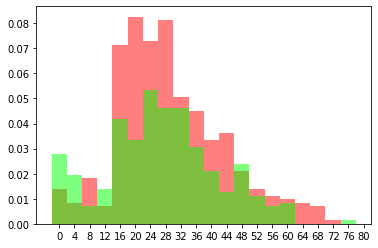

In [6]:
hist(survived, train["Age"].dropna().astype(int), color)

In [7]:
def normal_dist_generator(sigma):
    k = 1 / (sigma * math.sqrt(2 * math.pi))
    s = (2 * sigma ** 2)
    def normal_dist_func(z, rel):
        return k * math.exp(-(z - rel)**2 / s)
    return normal_dist_func


def discr(peak, miss):
    return lambda z, rel: (peak if z == rel else miss)


class Model:
    def __init__(self):
        self._df = None
        self._cols = None
        self._wf = None

    def relearn(self, df):
        self._df = df
        return self

    def reset_features(self, **kwargs):
        self._cols = list(kwargs.keys())
        self._wf = {}
        for feature, config in kwargs.items():
            if config["type"] == "finite":
                peak = config["peak"]
                miss = (1 - peak) / (len(config["values"]) - 1)
                self._wf[feature] = np.vectorize(discr(peak, miss))
            elif config["type"] == "gauss":
                sigma = config["sigma"]
                self._wf[feature] = np.vectorize(normal_dist_generator(sigma))
            else:
                raise ValueError("Unknown type: {}".format(config["type"]))
        return self

    def get_weight(self, z):
        col_weights = []
        for col, zv in z.iteritems():
            if zv != zv:
                continue
            binop = self._wf[col]
            col_weights.append(binop(zv, self._df[col].values))
        cw = np.column_stack(col_weights)
        # cw = pd.DataFrame(cw)
        return np.nansum(np.nanprod(cw, axis=1))

    def prob(self, z):
        z = z[set(z.columns) & set(self._cols)]
        total_count = np.size(self._df.index)
        weight = z.apply(self.get_weight, axis=1)
        return weight / total_count

    def cond_prob(self, z, prop, vals):
        assert prop not in z.columns, "Conditional probability of known value"
        assert prop in self._cols, "Conditional probability on ignored column"
        p = self.prob(z)
        c_props = []
        for val in vals:
            z_with_val = z.assign(**{prop: val})
            p_with_val = self.prob(z_with_val)
            c_prop = p_with_val / p
            c_props.append(c_prop)
        return pd.concat(c_props, axis=1)

def mean_succ_prob(m, sample, target, classes, splits=10):
    sz = len(sample.index) // splits
    res = []
    for split_id in range(splits):
        tra = pd.concat([sample[:split_id * sz], sample[(split_id + 1)* sz:]])
        tes = sample[split_id * sz:(split_id + 1)* sz]
        m.relearn(tra)
        pred = m.cond_prob(tes.drop(columns=[target]), target, classes)
        pred["best_prediction"] = pred.apply(lambda r: r.argmax(), axis=1)
        pred["actual"] = tes[target]
        pred["correct"] = pred["best_prediction"] == pred["actual"]
        res.append(np.mean(pred["correct"]))
    return np.mean(res)

In [174]:
exps = pd.DataFrame()
m = Model()

for sibsp in [.9, .8, .5]:
    for parch in [.9, .8, .5]:
        for pclass in [.9, .8, .5]:
            for sex in [.9, .8, .5]:
                for desk in [.9, .8, .5]:
                    for age in [.1, 1.0]:
                        m.reset_features(**{
                            "Sex": {"type": "finite", "peak": sex, "values": ["male", "female"]},
                            "Age": {"type": "gauss", "sigma": age},
                            "Pclass": {"type": "finite", "peak": pclass, "values": [1, 2, 3]},
                            "Desk": {"type": "finite", "peak": desk, "values": ["A", "B", "C", "D", "E", "F", "G"]},
                            "Survived": {"type": "finite", "peak": 1.0, "values": [0, 1]},
                            "SibSp": {"type": "gauss", "sigma": sibsp},
                            "Parch": {"type": "gauss", "sigma": parch},
                        })
                        p = mean_succ_prob(m, train, "Survived", [0, 1])
                        exps = exps.append(
                            pd.Series(
                                dict(
                                    sibsp=sibsp,
                                    parch=parch,
                                    pclass=pclass,
                                    sex=sex,
                                    desk=desk,
                                    age=age,
                                    p=p
                                )
                            ),
                            ignore_index=True
                        ).sort_values(by="p", ascending=False)

                        clear_output(wait=True)
                        display(exps)

,age,desk,p,parch,pclass,sex,sibsp
0,0.1,0.8,0.807865,0.9,0.5,0.9,0.8
2,0.1,0.8,0.806742,0.8,0.5,0.9,0.9
1,0.1,0.8,0.806742,0.9,0.5,0.9,0.9
3,1.0,0.8,0.805618,0.9,0.5,0.9,0.9
5,0.1,0.5,0.805618,0.9,0.5,0.9,0.8
...,...,...,...,...,...,...,...
480,0.1,0.5,0.644944,0.9,0.5,0.5,0.8
481,1.0,0.5,0.638202,0.8,0.5,0.5,0.8
482,1.0,0.5,0.635955,0.9,0.5,0.5,0.8
483,1.0,0.5,0.633708,0.9,0.5,0.5,0.9


In [8]:
non_parametric_v01 = Model().reset_features(**{
    "Sex": {"type": "finite", "peak": .9, "values": ["male", "female"]},
    "Age": {"type": "gauss", "sigma": .1},
    "Pclass": {"type": "finite", "peak": .5, "values": [1, 2, 3]},
    "Desk": {"type": "finite", "peak": .8, "values": ["A", "B", "C", "D", "E", "F", "G"]},
    "Survived": {"type": "finite", "peak": 1.0, "values": [0, 1]},
    "SibSp": {"type": "gauss", "sigma": .8},
    "Parch": {"type": "gauss", "sigma": .9},
})
mean_succ_prob(non_parametric_v01, train, "Survived", [0, 1])

0.8078651685393258

In [9]:
non_parametric_v01.relearn(train)
(
    (non_parametric_v01.cond_prob(test, "Survived", [0, 1])[1] > 0.5)
    .rename("Survived")
    .astype(int)
    .to_csv("../models/non_parametric_v01/non_parametric_v01.csv")
)